In [127]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import astropy.units as u
import ndcube
import sunpy.map
import astropy.wcs
from astropy.visualization import ImageNormalize, LogStretch, AsymmetricPercentileInterval
import distributed

from synthesizAR.instruments.util import extend_celestial_wcs

from overlappy.util import color_lat_lon_axes

from mocksipipeline.util import stack_components
from mocksipipeline.physics.spectral import SpectralModel
from mocksipipeline.detector.response import ThinFilmFilter
from mocksipipeline.detector.component import DispersedComponent

%matplotlib widget

In [24]:
def get_norm_from_percentile(data, lower_percentile=1, upper_percentile=99, unit=None, stretch=LogStretch()):
    interval = AsymmetricPercentileInterval(lower_percentile, upper_percentile)
    if unit is None:
        unit = data.unit
    vmin,vmax = interval.get_limits(data.to_value(unit))
    norm = ImageNormalize(vmin=vmin, vmax=vmax, stretch=stretch)
    return norm

# EM Distributions from Barnes et al. (2019)

In this notebook, I'm attempting to model some MOXSI observations based on some old simulations I did where I got an EM cube by inverting simulating AIA intensities that were averaged over 

In [2]:
def h5_emcube_to_ndcube(file, rebin=True, target_resolution=(5.66,5.66)*u.arcsec/u.pix):
    # Read in data
    with h5py.File(file) as hf:
        meta = dict(hf['meta'].attrs)
        em_data = u.Quantity(hf['emission_measure'][:], hf['emission_measure'].attrs['unit'])
        temperature_bin_edges = u.Quantity(hf['temperature_bin_edges'][:], hf['temperature_bin_edges'].attrs['unit'])
    
    # Calculate temperature bin centers
    log_bin_edges = np.log10(temperature_bin_edges.to_value('K'))
    log_bin_centers = (log_bin_edges[:-1] + log_bin_edges[1:])/2
    temperature_bin_centers = 10**log_bin_centers*u.K
    # Edit metadata
    for k in ['bitpix', 't_obs', 'temp_a', 'temp_b', 'temp_unit', 'tunit']:
        del meta[k]
    # Resample each slice down to a resolution closer to MOXSI
    rebinned_slices = []
    for i in range(em_data.shape[-1]):
        _m = sunpy.map.Map(em_data[...,i], meta)
        if rebin:
            superpix_size = np.floor([(target_resolution[0]/_m.scale.axis1).decompose(),
                                      (target_resolution[1]/_m.scale.axis2).decompose()])
            _m = _m.superpixel(superpix_size*u.pix, func=np.sum)
        rebinned_slices.append(_m.data)
    em_data_rebinned = u.Quantity(rebinned_slices, em_data.unit)
    rebinned_celestial_wcs = _m.wcs
    rebinned_meta = _m.meta
    # Construct NDCube
    full_wcs = extend_celestial_wcs(rebinned_celestial_wcs, temperature_bin_centers, 'temperature', 'phys.temperature')
    return ndcube.NDCube(em_data_rebinned, wcs=full_wcs, meta=rebinned_meta, )

In [3]:
em_hf = h5_emcube_to_ndcube('data/barnes_2019_em_cubes/em_cube_high_frequency.h5', rebin=True)

In [4]:
em_lf = h5_emcube_to_ndcube('data/barnes_2019_em_cubes/em_cube_low_frequency.h5')

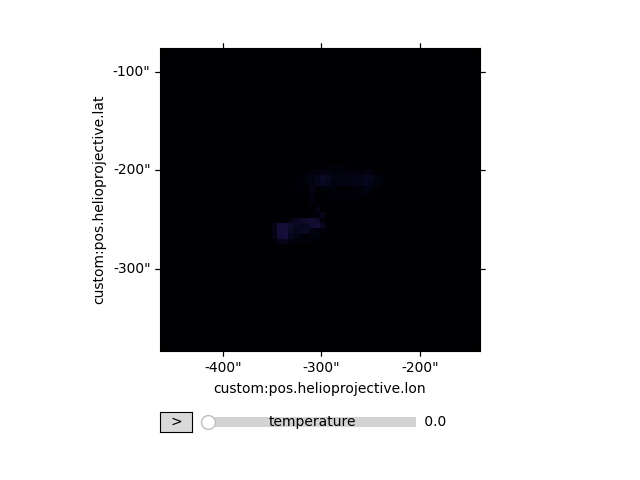

In [130]:
em_hf.plot(cmap='magma', norm=ImageNormalize(vmin=1e21, vmax=1e29, stretch=LogStretch()))

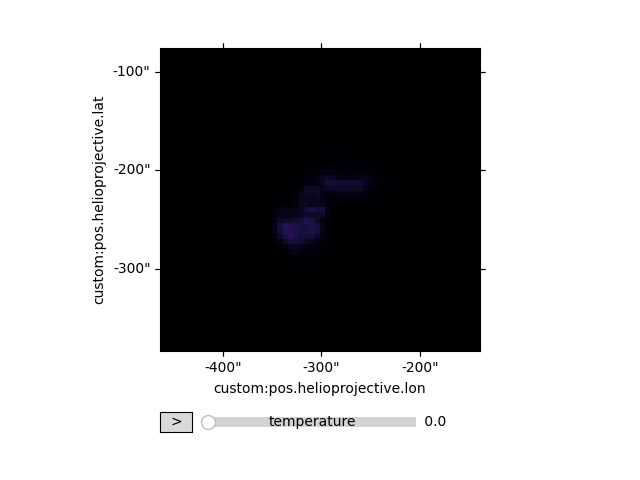

In [128]:
em_lf.plot(cmap='magma', norm=ImageNormalize(vmin=1e21, vmax=1e29, stretch=LogStretch()))

## Spectral Cube

In [6]:
spec_model = SpectralModel(spectral_table='sun_coronal_1992_feldman_ext_all')

In [7]:
spec_cube_hf = spec_model.run(em_hf, astropy.wcs.WCS(header=em_hf.meta))
spec_cube_lf = spec_model.run(em_lf, astropy.wcs.WCS(header=em_lf.meta))

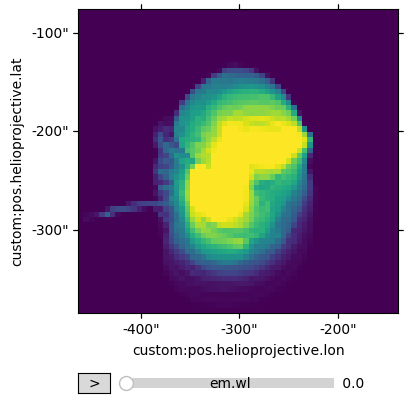

In [8]:
spec_cube_hf[400:500].plot(norm=ImageNormalize(vmin=1e8,vmax=1e14, stretch=LogStretch()))

## Compute Overlappogram

In [17]:
client = distributed.Client()

In [9]:
al_filter = ThinFilmFilter(elements='Al', thickness=150*u.nm, xrt_table='Chantler')

In [10]:
dc = DispersedComponent(al_filter, channel_kwargs={'full_detector': False})

In [18]:
overlappograms_hf = dc.compute(spec_cube_hf, include_gain=False, electrons=False)

/Users/wtbarnes/mambaforge/envs/mocksipipeline/lib/python3.9/site-packages/astropy/units/quantity.py:626: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/wtbarnes/mambaforge/envs/mocksipipeline/lib/python3.9/site-packages/astropy/units/quantity.py:626: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
  'angstrom' -> 'Angstrom'. [astropy.wcs.wcs]
/Users/wtbarnes/mambaforge/envs/mocksipipeline/lib/python3.9/site-packages/astropy/units/quantity.py:626: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
  'angstrom' -> 'Angstrom'. [astropy.wcs.wcs]
/Users/wtbarnes/mambaforge/envs/mocksipipeline/lib/python3.9/site-packages/astropy/units/quantity.py:626: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *ar

In [21]:
total_overlappogram_hf = stack_components([v for k,v in overlappograms_hf.items()], wcs_index=2)

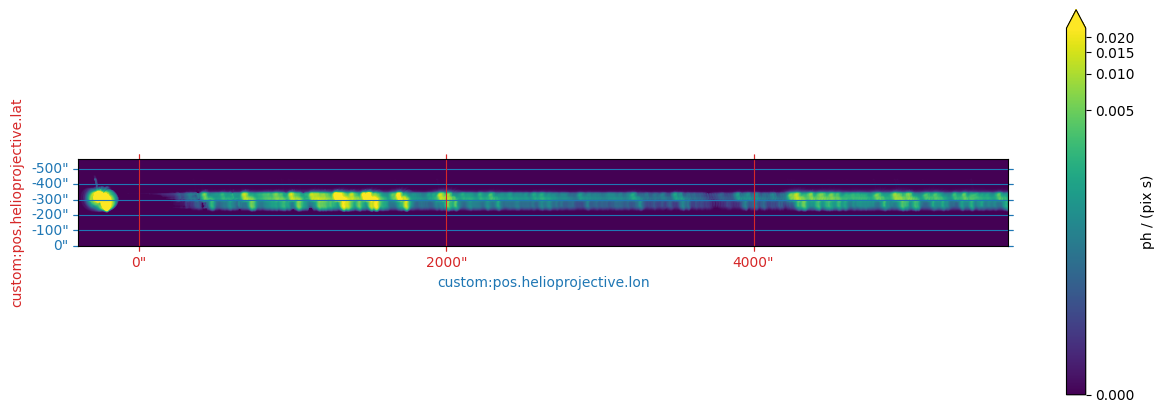

In [90]:
data_unit = u.Unit('photon / (pix s)')

fig = plt.figure(figsize=(15,5))
cropped_cube = total_overlappogram_hf[0,375:475,930:]

ax = fig.add_subplot(111, projection=cropped_cube.wcs)
cropped_cube.plot(
    axes=ax,
    norm=get_norm_from_percentile(cropped_cube.data*cropped_cube.unit, upper_percentile=99.5, lower_percentile=1, unit=data_unit),
    data_unit=data_unit,
    cmap='viridis',
)
color_lat_lon_axes(ax)
#ax.plot_coord(ar_slice, color='C2', ls='--')
cb = fig.colorbar(ax.get_images()[0], extend='max')
cb.set_label(data_unit)

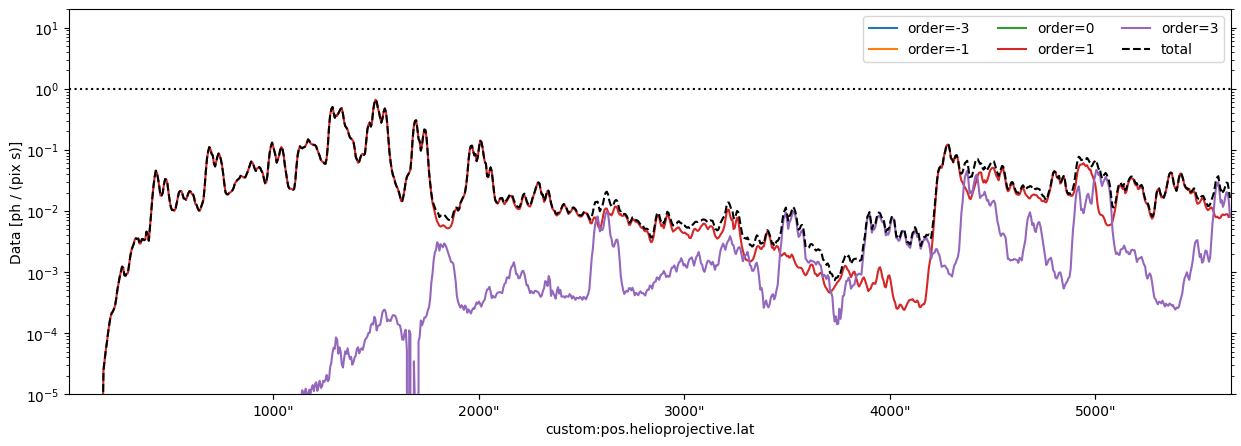

In [70]:
data_unit = 'ph / (pix s)'
fig = plt.figure(figsize=(15,5))
total_rebin = total_overlappogram_hf[0].rebin((total_overlappogram_hf[0].data.shape[0], 1),operation=np.sum)[0]
ax = fig.add_subplot(projection=total_rebin)
for order,component in overlappograms_hf.items():
    component[0].rebin((component[0].data.shape[0], 1),operation=np.sum)[0].plot(axes=ax, label=f'order={order}', data_unit=data_unit)
total_rebin.plot(axes=ax, color='k', ls='--', label='total', data_unit=data_unit)
ax.axhline(y=1, color='k', ls=':')
ax.set_yscale('log')
ax.set_ylim(1e-5, 20)
ax.set_xlim(1000,2000)
ax.legend(ncol=3)

In [85]:
overlappograms_lf = dc.compute(spec_cube_lf, include_gain=False, electrons=False)

/Users/wtbarnes/mambaforge/envs/mocksipipeline/lib/python3.9/site-packages/astropy/units/quantity.py:626: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
  'angstrom' -> 'Angstrom'. [astropy.wcs.wcs]
/Users/wtbarnes/mambaforge/envs/mocksipipeline/lib/python3.9/site-packages/astropy/units/quantity.py:626: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
  'angstrom' -> 'Angstrom'. [astropy.wcs.wcs]
/Users/wtbarnes/mambaforge/envs/mocksipipeline/lib/python3.9/site-packages/astropy/units/quantity.py:626: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
  'angstrom' -> 'Angstrom'. [astropy.wcs.wcs]
/Users/wtbarnes/mambaforge/envs/mocksipipeline/lib/python3.9/site-packages/astropy/units/quantity.py:626: RuntimeWarning: divide by zero encountered in divide
  result =

In [86]:
total_overlappogram_lf = stack_components([v for k,v in overlappograms_lf.items()], wcs_index=2)

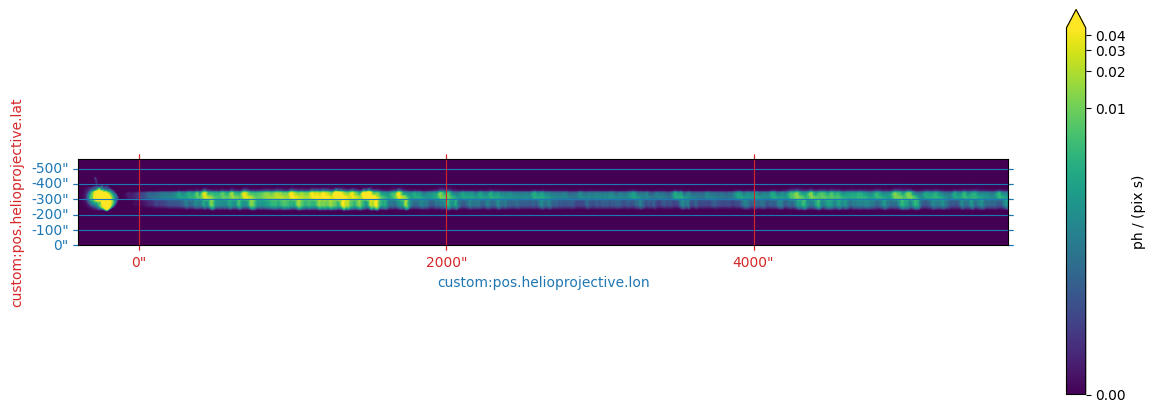

In [89]:
data_unit = u.Unit('photon / (pix s)')

fig = plt.figure(figsize=(15,5))
cropped_cube = total_overlappogram_lf[0,375:475,930:]#[0,375:475,930:1500]

ax = fig.add_subplot(111, projection=cropped_cube.wcs)
cropped_cube.plot(
    axes=ax,
    norm=get_norm_from_percentile(cropped_cube.data*cropped_cube.unit, upper_percentile=99.5, lower_percentile=1, unit=data_unit),
    data_unit=data_unit,
    cmap='viridis',
)
color_lat_lon_axes(ax)
#ax.plot_coord(ar_slice, color='C2', ls='--')
cb = fig.colorbar(ax.get_images()[0], extend='max')
cb.set_label(data_unit)

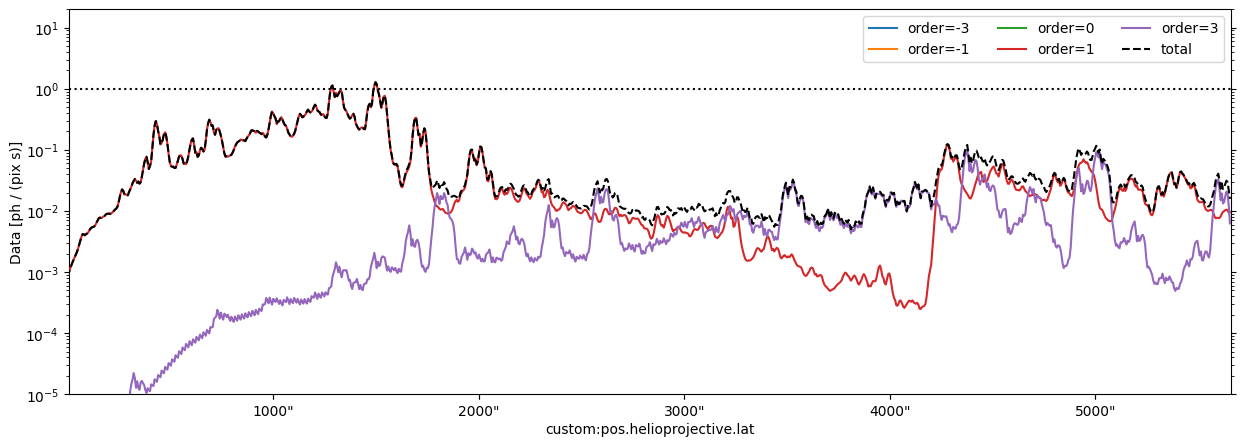

In [91]:
data_unit = 'ph / (pix s)'
fig = plt.figure(figsize=(15,5))
total_rebin = total_overlappogram_lf[0].rebin((total_overlappogram_lf[0].data.shape[0], 1),operation=np.sum)[0]
ax = fig.add_subplot(projection=total_rebin)
for order,component in overlappograms_lf.items():
    component[0].rebin((component[0].data.shape[0], 1),operation=np.sum)[0].plot(axes=ax, label=f'order={order}', data_unit=data_unit)
total_rebin.plot(axes=ax, color='k', ls='--', label='total', data_unit=data_unit)
ax.axhline(y=1, color='k', ls=':')
ax.set_yscale('log')
ax.set_ylim(1e-5, 20)
ax.set_xlim(1000,2000)
ax.legend(ncol=3)

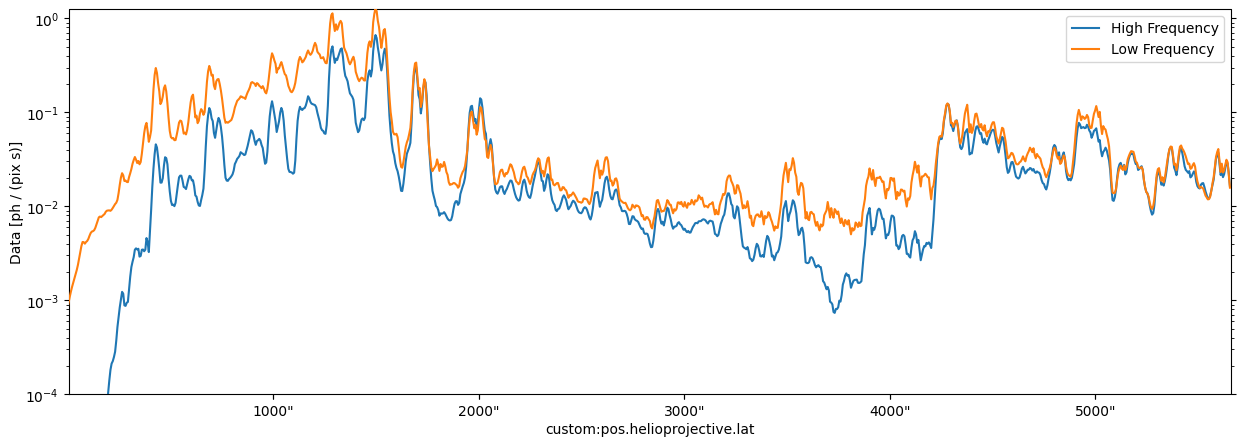

In [100]:
data_unit = 'ph / (pix s)'
fig = plt.figure(figsize=(15,5))
total_rebin_hf = total_overlappogram_hf[0].rebin((total_overlappogram_hf[0].data.shape[0], 1),operation=np.sum)[0]
total_rebin_lf = total_overlappogram_lf[0].rebin((total_overlappogram_lf[0].data.shape[0], 1),operation=np.sum)[0]
ax = fig.add_subplot(projection=total_rebin_hf)
total_rebin_hf.plot(axes=ax, label='High Frequency', data_unit=data_unit)
total_rebin_lf.plot(axes=ax, label='Low Frequency', data_unit=data_unit)
ax.set_yscale('log')
ax.set_ylim(1e-4, 1.25)
ax.set_xlim(1000,2000)
ax.legend()

In [102]:
intensity_ratio = total_rebin_lf.data / total_rebin_hf.data

(930.0, 2000.0)

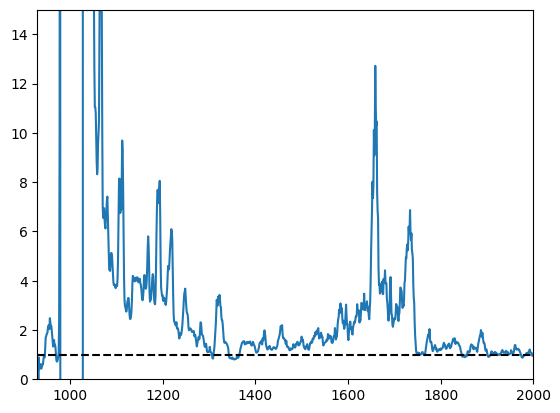

In [108]:
plt.plot(intensity_ratio)
plt.ylim(0,15)
plt.axhline(y=1, ls='--', color='k')
plt.xlim(930,2000)

In [116]:
%matplotlib inline

(<astropy.visualization.wcsaxes.coordinate_helpers.CoordinateHelper at 0x327f35a30>,
 <astropy.visualization.wcsaxes.coordinate_helpers.CoordinateHelper at 0x322aa29d0>)

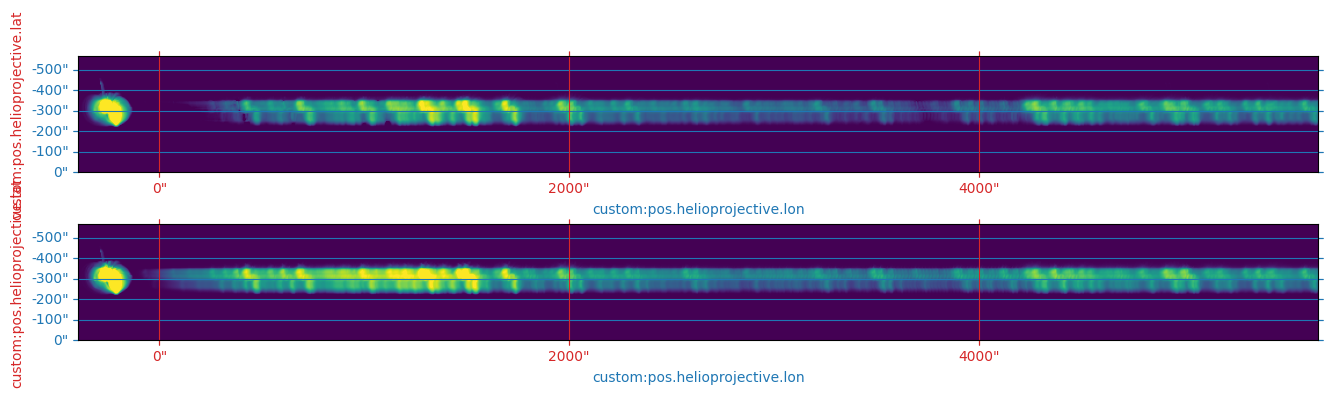

In [120]:
data_unit = u.Unit('photon / (pix s)')

fig = plt.figure(figsize=(16,4))
sl = np.s_[0,375:475,930:]
cropped_cube_hf = total_overlappogram_hf[sl]
cropped_cube_lf = total_overlappogram_lf[sl]

norm = get_norm_from_percentile(cropped_cube_lf.data*cropped_cube_lf.unit, upper_percentile=99.5, lower_percentile=1, unit=data_unit)

ax = fig.add_subplot(211, projection=cropped_cube_hf.wcs)
cropped_cube_hf.plot(
    axes=ax,
    norm=norm,
    data_unit=data_unit,
    cmap='viridis',
)
color_lat_lon_axes(ax)
ax = fig.add_subplot(212, projection=cropped_cube_lf.wcs)
cropped_cube_lf.plot(
    axes=ax,
    norm=norm,
    data_unit=data_unit,
    cmap='viridis',
)
color_lat_lon_axes(ax)
#ax.plot_coord(ar_slice, color='C2', ls='--')
#cb = fig.colorbar(ax.get_images()[0], extend='max')
#cb.set_label(data_unit)

In [ ]:
em_hf